## 0. Setup packages and Constants

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import uproot
import numpy as np
import sys
from tqdm import tqdm

# Utils
from utils import plotters

plt.style.use('./utils/style.mplstyle')

%load_ext autoreload
%autoreload 2

In [59]:
#Path to the ROOT file containing the universe covariance matrices
DATA_PATH = '/exp/sbnd/data/users/brindenc/xsec_analysis/test/sbruce/uni_med_weight3.root'

#Bin indices for the covariance matrix
P_BINS = np.arange(0, 10)
COSTHETA_OVERFLOW_BINS = np.arange(10, 20)
COSTHETA_BINS = np.arange(10,19)

# 1. Load the data

In [60]:
tree = uproot.open(DATA_PATH)
keys = tree.keys()
#tree.keys() #display all keys in the ROOT file

In [61]:
len(keys)

474111

In [62]:
key = 'SBND_CC1muX_1D/+exp+sbnd+data+users+brindenc+xsec_analysis+test+sbruce+cc1mux_med_weight_copy.root/unweighted_0_reco;1'
tree[key].to_hist()

Hist(Regular(18, 0, 18, name='xaxis', label=' reco bin number'), storage=Weight()) # Sum: WeightedSum(value=249, variance=249)

In [78]:
p_nan_keys = []
costheta_nan_keys = []
wrong_length_keys = []
dir_keys = []
non_hist_keys = []
accepted_keys = []
negative_keys = []
zero_keys = []


#Check for nan values in the universes
for i,_key in tqdm(enumerate(keys)):
  # if i > 1000:
  #   break
  #print(i,_key)
  _tree = tree[_key]
  #skip directories
  if '.root/' not in _key: 
    dir_keys.append(_key)
    continue
  
  #skip non-histograms
  if _tree.classname != 'TH1D':
    non_hist_keys.append(_key)
    continue
  
  #Check if the histogram has the correct number of bins
  if (len(_tree.to_numpy()[0]) != (len(P_BINS) + len(COSTHETA_BINS))) \
    and (len(_tree.to_numpy()[0]) != (len(P_BINS) + len(COSTHETA_OVERFLOW_BINS))): #account for overflow bin 
    
    #print(f'Incorrect number of bins for {_key}')
    wrong_length_keys.append(_key)
    continue
  #Which keys do we use depends on which length it matches
  if len(_tree.to_numpy()[0]) == (len(P_BINS) + len(COSTHETA_BINS)):
    costheta_bins = COSTHETA_BINS
  elif len(_tree.to_numpy()[0]) == (len(P_BINS) + len(COSTHETA_OVERFLOW_BINS)):
    costheta_bins = COSTHETA_OVERFLOW_BINS
  
  #Get universe values for the momentum histogram
  p_vals = _tree.to_numpy()[0][P_BINS]
  if np.isnan(p_vals).sum() > 0:
    p_nan_keys.append(_key)
  
  #Get universe values for the costheta histogram
  costheta_vals = _tree.to_numpy()[0][costheta_bins]
  if np.isnan(costheta_vals).sum() > 0:
    costheta_nan_keys.append(_key)
    
  #Check for negative values
  if (p_vals < 0).sum() > 0:
    negative_keys.append(_key)
  if (costheta_vals < 0).sum() > 0:
    negative_keys.append(_key)
  
  #Check for zero values
  if (p_vals == 0).sum() > 0:
    zero_keys.append(_key)
  if (costheta_vals == 0).sum() > 0:
    zero_keys.append(_key)
    
  accepted_keys.append(_key)

0it [00:00, ?it/s]

474111it [09:55, 795.92it/s] 


In [79]:
len(tree['SBND_CC1muX_1D/+exp+sbnd+data+users+brindenc+xsec_analysis+test+sbruce+cc1mux_med_weight.root/unweighted_0_reco;1'].to_numpy()[0]),\
len(tree['SBND_CC1muX_1D/+exp+sbnd+data+users+brindenc+xsec_analysis+test+sbruce+cc1mux_med_weight.root/unweighted_0_reco;1'].to_numpy()[1])

(18, 19)

In [80]:
len(wrong_length_keys),len(dir_keys),len(non_hist_keys),len(p_nan_keys),len(costheta_nan_keys),len(accepted_keys)

(0, 94839, 252848, 0, 0, 126424)

In [81]:
wrong_length_th1d = tree[wrong_length_keys[0]].to_numpy()
correct_length_th1d = tree[accepted_keys[0]].to_numpy()
len(wrong_length_th1d[0]), len(P_BINS) + len(COSTHETA_BINS), len(correct_length_th1d[0])

IndexError: list index out of range

In [68]:
correct_length_th1d[0],accepted_keys[0]

(array([11.,  4.,  9.,  9., 19., 16., 13., 22., 22., 21., 33., 25., 21.,
         9.,  4.,  4.,  6.,  1.]),
 'SBND_CC1muX_1D/+exp+sbnd+data+users+brindenc+xsec_analysis+test+sbruce+cc1mux_med_weight.root/unweighted_0_reco;1')

In [69]:
len(wrong_length_th1d[1]),len(tree[key].to_numpy()[1])

(19, 19)

(array([1., 3., 1., 0., 3., 1., 1., 0., 1., 0., 1., 4., 0., 1., 0., 0., 0.,
        1.]),
 array([ 1.        ,  2.77777778,  4.55555556,  6.33333333,  8.11111111,
         9.88888889, 11.66666667, 13.44444444, 15.22222222, 17.        ,
        18.77777778, 20.55555556, 22.33333333, 24.11111111, 25.88888889,
        27.66666667, 29.44444444, 31.22222222, 33.        ]),
 <BarContainer object of 18 artists>)

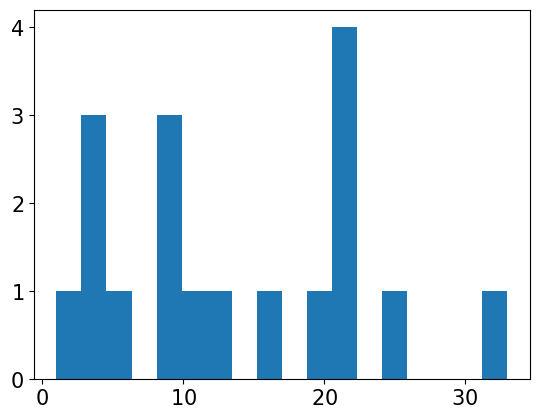

In [23]:
P_BINS,COSTHETA_BINS

(array([0, 1, 2, 3, 4, 5, 6, 7, 8]),
 array([ 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]))

In [29]:
_tree.classnames()
tree[key].classnames()

AttributeError: 'Model_TH1D_v2' object has no attribute 'classnames'